In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

In [3]:
%%time
# read in the entire dataset
adata = sc.read_h5ad("02_before_preprocessing.h5ad")

CPU times: user 132 ms, sys: 475 ms, total: 607 ms
Wall time: 606 ms


In [6]:
Counter(adata.obs.age)

Counter({18: 75724})

In [8]:
Counter(adata.obs.donor_id)

Counter({'Penn_F2': 38729, 'Penn_F1': 36995})

In [9]:
# confirm that these are the raw counts
adata.X.sum(axis = 1)

matrix([[ 537.],
        [ 463.],
        [ 962.],
        ...,
        [ 540.],
        [2171.],
        [ 889.]])

In [10]:
adata.layers['counts'] = adata.X

In [12]:
# extract the relevant metadata
metadata = adata.obs[['sample_id', 'sex', 'age', 'age_status', 'region', 'donor_id']]

# add additional metadata columns
metadata['study'] = 'Penn'
metadata['technology'] = 'Dropseq'
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['disease'] = 'ND'

# add back the metadata
adata.obs = metadata
adata.obs.head()

/mnt/data1/william/tmp/ipykernel_3670283/3687671068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['study'] = 'Penn'
/mnt/data1/william/tmp/ipykernel_3670283/3687671068.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['technology'] = 'Dropseq'
/mnt/data1/william/tmp/ipykernel_3670283/3687671068.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,sample_id,sex,age,age_status,region,donor_id,study,technology,cell_or_nuclei,disease
index,,,,,,,,,,
Fetal-1st-LV-0315-2-run1n2:AAAAAAACTGGC,Fetal-1st-LV-0315-2-run1n2,female,18,Fetal,LV,Penn_F1,Penn,Dropseq,Nuclei,ND
Fetal-1st-LV-0315-2-run1n2:AAAAAAGCCCCT,Fetal-1st-LV-0315-2-run1n2,female,18,Fetal,LV,Penn_F1,Penn,Dropseq,Nuclei,ND
Fetal-1st-LV-0315-2-run1n2:AAAAAAGGGCGG,Fetal-1st-LV-0315-2-run1n2,female,18,Fetal,LV,Penn_F1,Penn,Dropseq,Nuclei,ND
Fetal-1st-LV-0315-2-run1n2:AAAAACTCCCTA,Fetal-1st-LV-0315-2-run1n2,female,18,Fetal,LV,Penn_F1,Penn,Dropseq,Nuclei,ND
Fetal-1st-LV-0315-2-run1n2:AAAAACTGGCGG,Fetal-1st-LV-0315-2-run1n2,female,18,Fetal,LV,Penn_F1,Penn,Dropseq,Nuclei,ND


In [13]:
# check that the var names are gene symbols, not ENSEMBL ID
adata.var_names

Index(['DDX11L2', 'MIR1302-2HG', 'FAM138A', 'ENSG00000290826', 'OR4F5',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599',
       ...
       'ENSG00000275249', 'ENSG00000274792', 'ENSG00000274175',
       'ENSG00000275869', 'ENSG00000273554', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=38606)

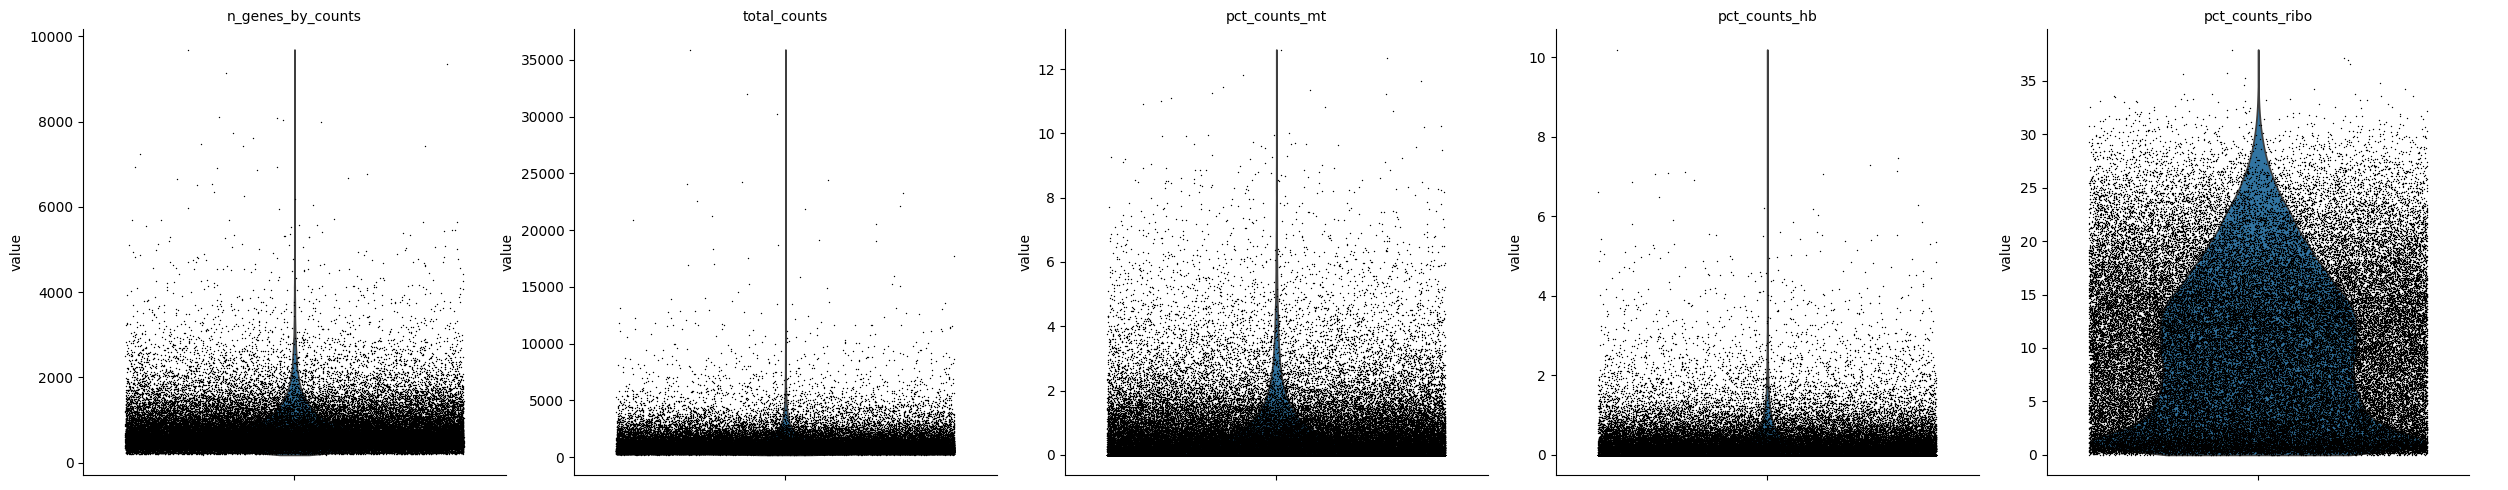

Filtered out 18559 cells
CPU times: user 23.7 s, sys: 26 s, total: 49.8 s
Wall time: 6.91 s


In [14]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 15.0
ribo_threshold = 15.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [16]:
%%time
# use sample since many replicates for each donor
donor_key = "sample_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 27 likely doublets
CPU times: user 12min 8s, sys: 13min 24s, total: 25min 33s
Wall time: 5min 4s


2024-11-23 21:12:50,880 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 21:12:54,761 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 21:12:55,730 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 21:13:14,458 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 21:13:31,308 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 21:13:49,722 - harmonypy - INFO - Iteration 4 of 10
2024-11-23 21:14:08,175 - harmonypy - INFO - Iteration 5 of 10
2024-11-23 21:14:23,381 - harmonypy - INFO - Iteration 6 of 10
2024-11-23 21:14:35,584 - harmonypy - INFO - Iteration 7 of 10
2024-11-23 21:14:47,270 - harmonypy - INFO - Converged after 7 iterations


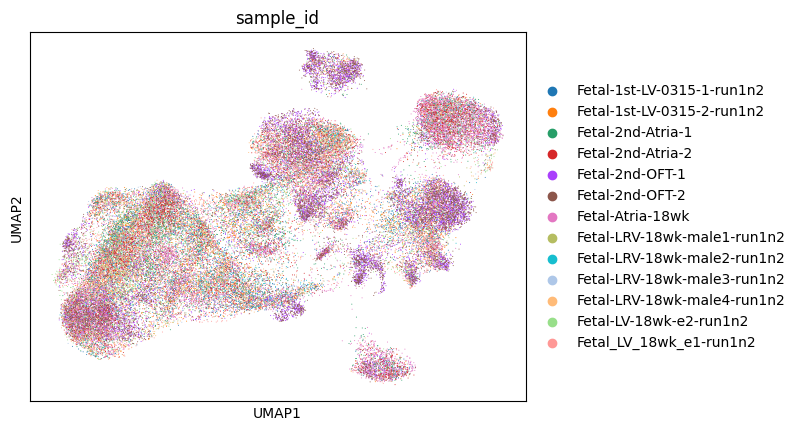

In [18]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "sample_id",
                         leiden_resolution = LEIDEN_RES)

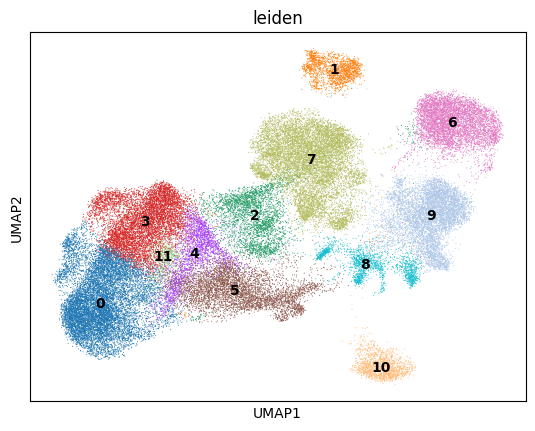

In [19]:
sc.pl.umap(adata, color=["leiden"], size=2, legend_loc = "on data")

### Identify marker genes

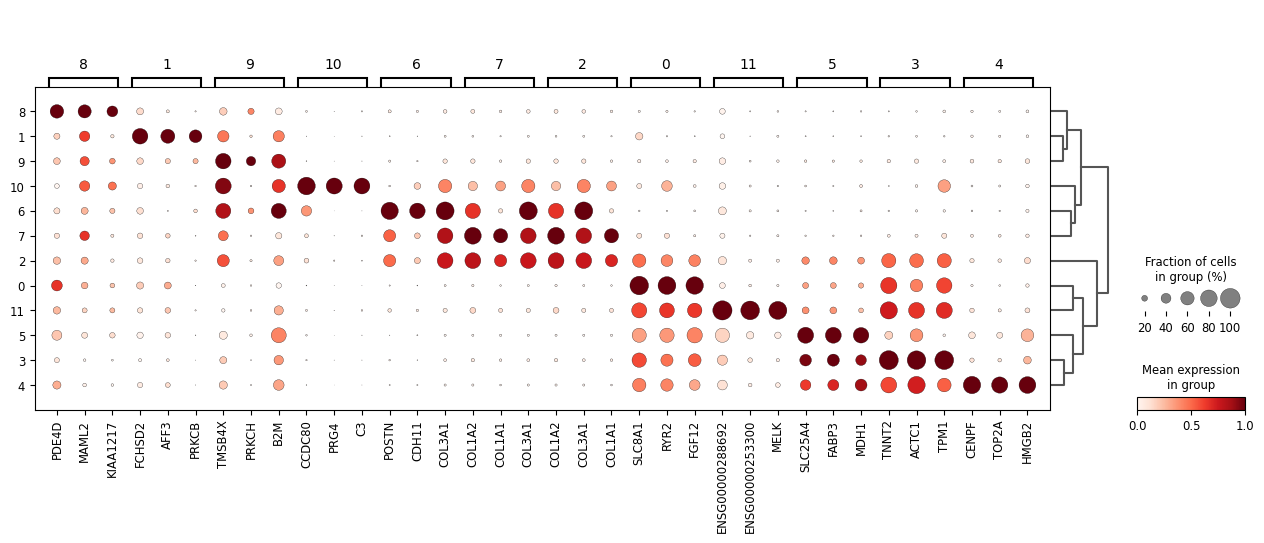

CPU times: user 4min 12s, sys: 25 s, total: 4min 37s
Wall time: 3min 3s


In [20]:
%%time
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=3)

In [42]:
sc.get.rank_genes_groups_df(adata, group="2").head(50)

,names,scores,logfoldchanges,pvals,pvals_adj
0,COL1A2,46.363758,1.704216,0.000000e+00,0.000000e+00
1,COL3A1,43.667423,1.599213,0.000000e+00,0.000000e+00
2,COL1A1,35.192863,1.776817,2.571030e-271,3.308573e-267
3,DCN,34.190395,1.904452,3.358997e-256,3.241936e-252
4,POSTN,30.145290,1.381599,1.236441e-199,9.546806e-196
5,SPARC,22.531334,1.026117,2.046954e-112,1.317078e-108
6,TPM1,22.461559,0.792585,9.866278e-112,5.441393e-108
7,PTN,21.620096,1.505019,1.162333e-103,5.609128e-100
8,MYL7,21.094912,0.816198,8.856975e-99,3.799248e-95
9,TNNT2,20.240301,0.695922,4.325174e-91,1.669777e-87


Based on these marker genes, the Leiden clusters correspond to:
- Cardiomyocytes: 0, 2, 3, 4, 10
- Fibroblast: 1, 11
- Endothelial: 7
- Lymphoid: 6, 12
- Neuronal: 5
- Pericyte: 8
- Epicardial: 9

In [43]:
adata.obs['cell_type'] = adata.obs['leiden'].map(
    {
        "0": "Cardiomyocyte",
        "1": "Myeloid",
        "2": "Doublet",
        "3": "Cardiomyocyte",
        "4": "Cardiomyocyte",
        "5": "Cardiomyocyte",
        "6": "Endothelial",
        "7": "Fibroblast",
        "8": "Neuronal",
        "9": "Lymphoid",
        "10": "Epicardial",
        "11": "Cardiomyocyte",
    }
)

In [44]:
adata.obs['consistent_cell_type'] = adata.obs['cell_type']

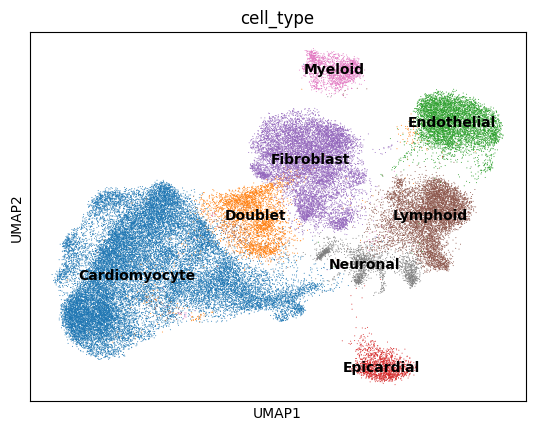

In [45]:
sc.pl.umap(adata, color=["cell_type"], size=2, legend_loc = "on data")

In [46]:
adata = adata[adata.obs.cell_type != "Doublet"].copy()
adata

AnnData object with n_obs × n_vars = 53696 × 38606
    obs: 'sample_id', 'sex', 'age', 'age_status', 'region', 'donor_id', 'study', 'technology', 'cell_or_nuclei', 'disease', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'cell_type', 'consistent_cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'uma

In [47]:
# save adata
adata.write("03_processed_Penn_fetal.h5ad")